In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.utils import gen_batches
from sklearn.metrics import classification_report, confusion_matrix
from typing import *
from numpy.linalg import *

train_image_file = './mnist/train-images-idx3-ubyte'
train_label_file = './mnist/train-labels-idx1-ubyte'
test_image_file = './mnist/t10k-images-idx3-ubyte'
test_label_file = './mnist/t10k-labels-idx1-ubyte'


def decode_image(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(-1, 784)
        images = np.array(images, dtype = float)
    return images

def decode_label(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack('>II',f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.array(labels, dtype = float)
    return labels

def load_data():
    train_X = decode_image(train_image_file)
    train_Y = decode_label(train_label_file)
    test_X = decode_image(test_image_file)
    test_Y = decode_label(test_label_file)
    return (train_X, train_Y, test_X, test_Y)

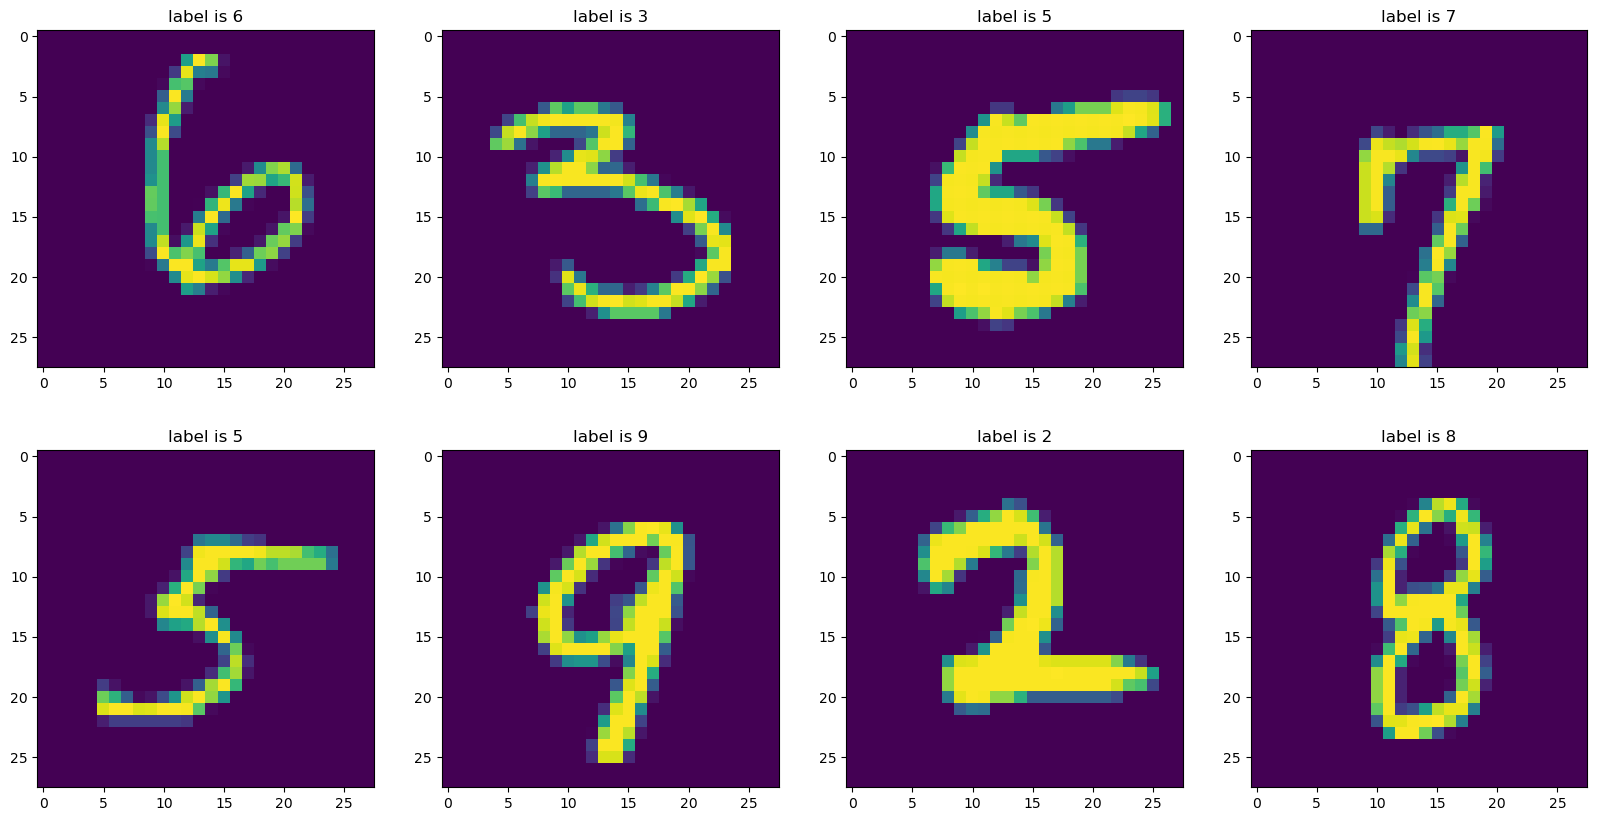

In [2]:
trainX, trainY, testX, testY = load_data()

num_train, num_feature = trainX.shape
plt.figure(1, figsize=(20,10))
for i in range(8):
    idx = np.random.choice(range(num_train))
    plt.subplot(int('24'+str(i+1)))
    plt.imshow(trainX[idx,:].reshape((28,28)))
    plt.title('label is %d'%trainY[idx])
plt.show()

In [3]:
# normalize the input value to make it between 0 and 1.
trainX, testX = trainX/255, testX/255

# convert labels to one-hot vector.
def to_onehot(y):
    y = y.astype(int)
    num_class = len(set(y))
    Y = np.eye((num_class))
    return Y[y]

trainY = to_onehot(trainY)
testY = to_onehot(testY)
num_train, num_feature = trainX.shape
num_test, _ = testX.shape
_, num_class = trainY.shape
print('number of features is %d'%num_feature)
print('number of classes is %d'%num_class)
print('number of training samples is %d'%num_train)
print('number of testing samples is %d'%num_test)
print('shape of training data is ' + str(trainX.shape))
print('shape of training data label is ' + str(trainX.shape))
print('shape of testing data is ' + str(testX.shape))
print('shape of testing data label is ' + str(testX.shape) )

number of features is 784
number of classes is 10
number of training samples is 60000
number of testing samples is 10000
shape of training data is (60000, 784)
shape of training data label is (60000, 784)
shape of testing data is (10000, 784)
shape of testing data label is (10000, 784)


In [42]:
from abc import ABC, abstractmethod, abstractproperty

class Activation(ABC):
    '''
    An abstract class that implements an activation function
    '''
    @abstractmethod
    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Value of the activation function when input is x.
        Parameters:
          x is an input to the activation function.
        Returns: 
          Value of the activation function. The shape of the return is the same as that of x.
        '''
        return x
    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Derivative of the activation function with input x.
        Parameters:
          x is the input to activation function
        Returns: 
          Derivative of the activation function w.r.t x.
        '''
        return x

class Identity(Activation):
    '''
    Identity activation function. Input and output are identical. 
    '''

    def __init__(self):
        super(Identity, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        return x
    
    def derivative(self, x: np.ndarray) -> np.ndarray:
        n, m = x.shape
        return np.ones((n, m))
    

class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        return 1/(1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        y = self.value(x)
        return y * (1 - y)
    
class ReLU(Activation):
    '''
    Rectified linear unit activation function
    '''

    def __init__(self):
        super(ReLU, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        #### write your code below ####
        
        return 0.005*np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:  
        relu = np.where(x >0, 1, 0)#大于0为1，小于等于0为0
        return relu


class Softmax(Activation):
    '''
    softmax nonlinear function.
    '''

    def __init__(self):
        '''
        There are no parameters in softmax function.
        '''
        super(Softmax, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Parameters:
          x is the input to the softmax function. x is a two dimensional numpy array. Each row is the input to the softmax function
        Returns:
          output of the softmax function. The returned value is with the same shape as that of x.
        '''
        #### write your code below ####
        # compute the exponential of each element of x
        exps = np.exp(x)
        # normalize by dividing each element by the sum of all exponentials
        return exps / np.sum(exps, axis=1, keepdims=True)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        s = self.value(x)
        n, m = x.shape
        ds = np.zeros((n, m))
        for i in range(n):
            for j in range(m):
                for k in range(m):
                    if j == k:
                        ds[i,j] += s[i,j] * (1 - s[i,j])
                    else:
                        ds[i,j] -= s[i,j] * s[i,k]
        return ds

For neural network for multi-class classification, the last layer is usually a softmax activation function. The output of the softmax function together with true targets or labels are used to compute the loss function. If both the softmax function and the loss function are computed independently, there are at least one drawbacks:

> The derivative of the softmax function w.r.t. the input is a matrix, which is not like the elementwise derivative in ReLU or sigmoid. A batch of such derivatives forms a three dimensional tensor, making the computation complicated.

To mitigate such an issue, a common trick is to merge the computation of softmax function with the loss function. In other words, the inputs to the loss function is the input to the softmax other than its output. In deep learning community, often the input to the softmax is regarded as unnormalized probability and is called logits. Being called logits is not exactly correct in math but is widely used. Let $\boldsymbol{z}$ be the logits, the output of the softmax function $\hat{\boldsymbol{y}}$ is defined as

$\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}, i = 1, \cdots, k$

the cross entropy loss is computed as follows:

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i\log(\hat{y}_i) = \sum_{i=1}^k y_i\log\left(\frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}\right) = \sum_{i=1}^k y_i z_i - \sum_{i=1}^k y_i\log(\sum_{j=1}^ke^{z_j})= \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j})$

In the above expression, there is a log-sum-exponential term, which often appears in research papers and text book. The reason people prefer the log-sum-exponential term is that it is easy to deal with overflow problem. For instance, there is

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{\beta}e^{-\beta}e^{z_j})= \sum_{i=1}^k y_i z_i -\beta - \log(\sum_{j=1}^ke^{z_j-\beta})$

By letting $\beta = \max z_i$, exponential terms in the exponential expression are all negative, avoiding the overflow problem.

The derivative of the above loss function is computed as follows:

$\frac{\partial L}{\partial z_i} = y_i - \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$
, where the expression $\frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$ is exactly the $i$th output of the softmax function. Thus,

$\frac{\partial L}{\partial \boldsymbol{z}} = \boldsymbol{y} - \text{softmax}(\boldsymbol{z})$

In [78]:
##################################################################################################################
# LOSS FUNCTIONS
##################################################################################################################

class Loss(ABC):
    '''
    Abstract class for a loss function
    '''
    @abstractmethod
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        '''
        Value of the empirical loss function.
        Parameters:
          y_hat is the output of a neural network. The shape of y_hat is (n, k). Each row represents the one sample output.
          y contains true labels with shape (n, k).
        Returns:
          value of the empirical loss function.
        '''
        return 0

    @abstractmethod
    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        '''
        Derivative of the empirical loss function with respect to the predictions.
        Parameters:
          
        Returns:
          The derivative of the loss function w.r.t. y_hat. The returned value is a two dimensional array with 
          shape (n, k)
        '''
        return yhat

class CrossEntropy(Loss):
    '''
    Cross entropy loss function
    '''

    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        #### write your code below ####
        # compute the cross entropy loss for each sample
        # use this formula when y and yhat are not one-hot encoded
        loss = -np.sum(y * np.log(yhat) + (1 - y) * np.log(1 - yhat), axis=1)
        # compute the average loss over all samples
        return np.mean(loss)

    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        #### write your code below ####
        # compute the derivative of cross entropy loss w.r.t. yhat
        return -y / yhat + (1 - y) / (1 - yhat)


class CEwithLogit(Loss):
    '''
    Cross entropy loss function with logits (input of softmax activation function) and true labels as inputs.
    '''
    def value(self, logits: np.ndarray, y: np.ndarray) -> float: 
        #### write your code below #### 
        # compute the cross entropy loss using logits and avoiding overflow problem 
        # use this formula when y is one-hot encoded 
        beta = np.max(logits) 
        log_sum_exp = beta + np.log(np.sum(np.exp(logits - beta), axis=1)) 
        loss = -np.sum(y * logits, axis=1) + log_sum_exp # compute the average loss over all samples 
        return np.mean(loss)
        

    def derivative(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        #### write your code below ####
        # compute the softmax output of logits
        yhat = Softmax().value(logits)
        # compute the derivative of cross entropy loss and softmax function w.r.t. logits
        return yhat - y

In [79]:
##################################################################################################################
# METRICS
##################################################################################################################

def accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    '''
    Accuracy of predictions, given the true labels.
    Parameters:
      y_hat is the outputs of softmax function. y_hat is with the shape (n, k).
      y is the true targets. y is with the shape (n, k).
    Returns:
      accuracy which is a float number.
    '''
    # get the predicted class for each sample
    y_pred = np.argmax(y_hat, axis=1)
    # get the true class for each sample
    y_true = np.argmax(y, axis=1)
    # count the number of correct predictions
    num_correct = np.sum(y_pred == y_true)
    # calculate the accuracy as the fraction of correct predictions
    accuracy = num_correct / y.shape[0]
    return accuracy

In [80]:
# The following is the python class for neural network.
# Using this class, users can design a neural network with any number of layers within which there could be any number of neuros

class NeuralNetwork():
    '''
    Fully connected neural network.
    Attributes:
      n_layers is the number of layers.
      activation is a list of Activation objects corresponding to each layer's activation function.
      loss is a Loss object corresponding to the loss function used to train the network.
      learning_rate is the learning rate.
      W is a list of weight matrix used in each layer.
      b is a list of biases used in each layer.
    '''

    def __init__(self, layer_size: List[int], activation: List[Activation], loss: Loss, learning_rate: float = 0.01) -> None:
        '''
        Initializes a NeuralNetwork object
        '''
        assert len(activation) == len(layer_size), \
        "Number of sizes for layers provided does not equal the number of activation"
        self.layer_size = layer_size
        self.num_layer = len(layer_size)
        self.activation = activation
        self.loss = loss
        self.learning_rate = learning_rate
        self.W = []
        self.b = []
        for i in range(self.num_layer-1):
            W = np.random.randn(layer_size[i], layer_size[i+1]) #/ np.sqrt(layer_size[i])
            b = np.random.randn(1, layer_size[i+1])
            self.W.append(W)
            self.b.append(b)
        self.A = []
        self.Z = []

    def forward(self, X: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        '''
        Forward pass of the network on a dataset of n examples with m features. Except the first layer, each layer
        computes linear transformation plus a bias followed by a nonlinear transformation.
        Parameters:
          X is the training data with shape (n, m).
        Returns:
          A is a list of numpy data, representing the output of each layer after the first layer. There are 
            self.num_layer numpy arrays in the list and each array is of shape (n, self.layer_size[i]).
          Z is a list of numpy data, representing the input of each layer after the first layer. There are
            self.num_layer numpy arrays in the list and each array is of shape (n, self.layer_size[i]).
        '''
        num_sample = X.shape[0]
        A, Z = [], []
        #### write your code below ####
        # initialize the input of the first layer as X
        self.X = X
        a = X
        # loop over each layer except the last one
        for i in range(self.num_layer-1):
            # compute the linear transformation z = a * W + b
            z = np.dot(a, self.W[i]) + self.b[i]
            # compute the nonlinear transformation a = activation(z)
            a = self.activation[i].value(z)
            # store z and a in Z and A
            Z.append(z)
            A.append(a)
        # return Z and A
        self.A = A
        self.Z = Z
        return Z, A

    def backward(self, dLdyhat) -> List[np.ndarray]:
        '''
        Backward pass of the network on a dataset of n examples with m features. The derivatives are computed from 
          the end of the network to the front.
        Parameters:
          dLdyhat is the derivative of the empirical loss w.r.t. yhat which is the output of the neural network.
            dLdyhat is with shape (n, self.layer_size[-1])
        Returns:
          dZ is a list of numpy array. Each numpy array in dZ represents the derivative of the emipirical loss function
            w.r.t. the input of that specific layer. There are self.n_layer arrays in the list and each array is of 
            shape (n, self.layer_size[i])
        '''
        dZ = []
        #### write your code below ####
        # initialize the derivative of loss w.r.t. output as dLdyhat
        delta = dLdyhat
        # loop over each layer from last to first
        for i in reversed(range(self.num_layer-1)):
            # compute the derivative of loss w.r.t. input as delta * activation'(z)
            dz = delta * self.activation[i].derivative(self.Z[i])
            # store dz in dZ at the beginning
            dZ.insert(0, dz)
            # compute the derivative of loss w.r.t. previous output as dz * W.T
            delta = np.dot(dz, self.W[i].T)
        # return dZ
        self.dZ = dZ
        return dZ

    def update_weights(self) -> List[np.ndarray]:
        '''
        Having computed the delta values from the backward pass, update each weight with the sum over the training
        examples of the gradient of the loss with respect to the weight.
        Parameters:
          there is no input parameters
        Returns:
          W is the newly updated weights (i.e. self.W)
        '''
        #### write your code below ####
        # initialize previous output as X
        a_prev = self.X
        # loop over each layer except last one
        for i in range(self.num_layer-1):
            # compute gradient of loss w.r.t. weight as a_prev.T * dz / n
            dw = np.dot(a_prev.T, self.dZ[i]) / num_sample
            # compute gradient of loss w.r.t. bias as sum of dz over axis 0 / n
            db = np.sum(self.dZ[i], axis=0, keepdims=True) / num_sample
            # update weight as W - learning_rate * dw
            self.W[i] -= self.learning_rate * dw
            # update bias as b - learning_rate * db
            self.b[i] -= self.learning_rate * db
            # update previous output as a
            a_prev = self.A[i]
        # return W
        return self.W
    
    def one_epoch(self, X: np.ndarray,  Y: np.ndarray, batch_size: int, train: bool = True)-> (float, float):
        '''
        One epoch of either training or testing procedure.
        Parameters:
          X is the data input. X is a two dimensional numpy array.
          Y is the data label. Y is a one dimensional numpy array.
          batch_size is the number of samples in each batch.
          train is a boolean value indicating training or testing procedure.
        Returns:
          loss_value is the average loss function value.
          acc_value is the prediction accuracy. 
        '''
        n = X.shape[0]
        slices = list(gen_batches(n, batch_size))
        num_batch = len(slices)
        idx = list(range(n))
        np.random.shuffle(idx)
        loss_value, acc_value = 0, 0
        for i, index in enumerate(slices):
            index = idx[slices[i]]
            x, y = X[index,:], Y[index]
            Z, A = model.forward(x)   # Execute forward pass
            yhat = A[-1]
            if train:
                dLdz = self.loss.derivative(Z[-1], y)# Calculate derivative of the loss with respect to out
                self.backward(dLdz)     # Execute the backward pass to compute the deltas
                self.update_weights()  # Calculate the gradients and update the weights
            loss_value += self.loss.value(yhat, y)*x.shape[0]
            acc_value += accuracy(yhat, y)*x.shape[0]
        loss_value = loss_value/n
        acc_value = acc_value/n
        return loss_value, acc_value

In [81]:
def train(model : NeuralNetwork, X: np.ndarray, Y: np.ndarray, batch_size: int, epoches: int) -> (List[np.ndarray], List[float]):
    '''
    trains the neural network.
    Parameters:
      model is a NeuralNetwork object.
      X is the data input. X is a two dimensional numpy array.
      Y is the data label. Y is a one dimensional numpy array.
      batch_size is the number of samples in each batch.
      epoches is an integer, representing the number of epoches.
    Returns:
      epoch_loss is a list of float numbers, representing loss function value in all epoches.
      epoch_acc is a list of float numbers, representing the accuracies in all epoches.
    '''
    loss_value, acc = model.one_epoch(X, Y, batch_size, train = False)
    epoch_loss, epoch_acc = [loss_value], [acc]
    print('Initialization: ', 'loss %.4f  '%loss_value, 'accuracy %.2f'%acc)
    for epoch in range(epoches):
        if epoch%100 == 0 and epoch > 0: # decrease the learning rate
            model.learning_rate = min(model.learning_rate/10, 1.0e-5)
        loss_value, acc = model.one_epoch(X, Y, batch_size, train = True)
        if epoch%1 == 0:
            print("Epoch {}/{}: Loss={}, Accuracy={}".format(epoch, epoches, loss_value, acc))
        epoch_loss.append(loss_value)
        epoch_acc.append(acc)
    return epoch_loss, epoch_acc

In [82]:
# training procedure
num_sample, num_feature = trainX.shape
epoches = 2
batch_size = 512
Loss = []
Acc = []
learning_rate = 1/num_sample*batch_size
np.random.seed(2023)
model = NeuralNetwork([784, 256, 64, 10], [Identity(), ReLU(), ReLU(), Softmax()], CEwithLogit(), learning_rate = learning_rate)
epoch_loss, epoch_acc = train(model, trainX, trainY, batch_size, epoches)
# testing procedure
test_loss, test_acc = model.one_epoch(testX, testY, batch_size, train = False)
z, yhat = model.forward(testX)
yhat = yhat[-1]
yhat = np.argmax(yhat, axis = 1)
y = np.argmax(testY, axis = 1)
print(confusion_matrix(yhat, y))
print(classification_report(yhat, y))

Initialization:  loss 2.3027   accuracy 0.11
Epoch 0/2: Loss=2.3022719705439605, Accuracy=0.11846666666666666
Epoch 1/2: Loss=2.301647001133583, Accuracy=0.14221666666666666
[[ 39 115 191 100  79  32  37 137  49  46]
 [ 87 142  26  13 113  69  67  46  26 167]
 [  5  92  27   4  83  13  70  58  25  86]
 [104 286  40 286  92 167 192  57  91 205]
 [344 106 190 128 135 175 257  55 281 150]
 [  1   3   5   0   0   1   2  12   0   2]
 [ 48 161  92  84  26  64 146  11  70  19]
 [155 147 112 175 218 237  83 611 205 194]
 [197  83 349 220 236 134 104  41 227 140]
 [  0   0   0   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.04      0.05      0.04       825
           1       0.13      0.19      0.15       756
           2       0.03      0.06      0.04       463
           3       0.28      0.19      0.23      1520
           4       0.14      0.07      0.10      1821
           5       0.00      0.04      0.00        26
           6    

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
